In [7]:
import sys
import os
import numpy as np
import pandas as pd
import gmaps
from mpl_toolkits.basemap import Basemap, maskoceans, cm
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
from matplotlib.pylab import subplots
from Fire_helpers import csv_to_df, df_to_heatmap
from settings_ECE180 import data_path
%matplotlib inline

In [8]:
# create dataframe and save output for each month with mean values
slice_data_dir = 'MM_CA_keep_landocean'
outdir = 'month_avg'

for i in range(1,13):
    # select month
    if i >= 10:
        MM = '{}'.format(i)
    else:
        MM = '0{}'.format(i)
    
    outf = 'FIRE-'+MM+'.csv'

    cc=0
    for dirpath, dnames, fnames in os.walk(os.path.join(data_path,slice_data_dir)):
        for f in fnames:
            if f.endswith(MM+".csv"):
                # load data
                if cc<1:
                    df1 = pd.read_csv(os.path.join('.','data',slice_data_dir ,f))
                    cc+=1
                else:
                    df = pd.read_csv(os.path.join('.','data',slice_data_dir ,f))
                    df1 = df1.append(df)

    # get rid of land mask (replace 0.1 with 0, because 0.1 represents land values)
    df1['mag'].replace(0.1,0, inplace=True)

    # Calculate mean values
    # Create a groupby variable that groups mag by lat and lon
    df2 = df1.groupby(['lat', 'lon']).mean()
    lon1 = df1['lon'].values
    lat1 = df1['lat'].values

    lon_avg = np.sort(list(set(lon1)))
    lat_avg = np.sort(list(set(lat1)))
    mag_avg = df2['mag'].values

    # create dataframe and save
    MM_df = pd.DataFrame({'lat':list(reversed(df['lat'].values)),'lon':df['lon'].values,'mag':mag_avg})
    # MM_df = MM_df.set_index('lat')
    # MM_df.sort_index(inplace=True)
    MM_df.to_csv
    MM_df.to_csv(os.path.join(data_path,outdir, outf))
    print outf + ': Done!'


FIRE-01.csv: Done!
FIRE-02.csv: Done!
FIRE-03.csv: Done!
FIRE-04.csv: Done!
FIRE-05.csv: Done!
FIRE-06.csv: Done!
FIRE-07.csv: Done!
FIRE-08.csv: Done!
FIRE-09.csv: Done!
FIRE-10.csv: Done!
FIRE-11.csv: Done!
FIRE-12.csv: Done!


['LosAngeles' 'SanDiego' 'SanJose' 'SanFrancisco' 'Fresno' 'Sacramento']


/Users/andre/anaconda3/envs/ECE180/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:4995: MatplotlibDeprecationWarning: The is_scalar function was deprecated in version 2.1.
  elif masked and is_scalar(masked):


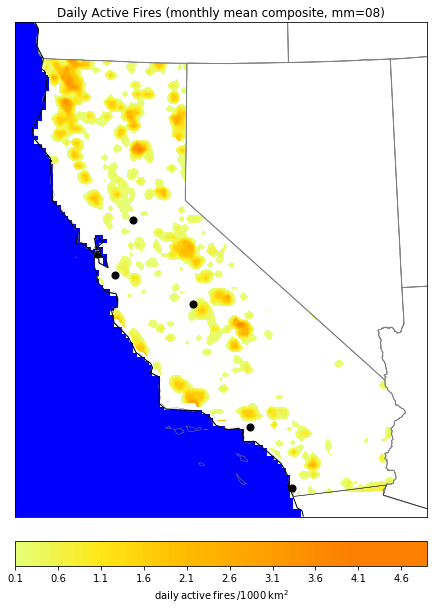

In [9]:
# TODO: make this an animation
# plot data for a single month (create contour maps)
outdir = 'month_avg'
# select month
MM = "08"
outf = 'FIRE-'+MM+'.csv'
# load data
MM_df = pd.read_csv(os.path.join('.','data',outdir,outf))

# download cities data
cities = pd.read_csv('./california_cities.csv')
# Extract city data (6 most populous cities)
Ncities = 6
cnames = cities.sort_values(by=['population_total'], ascending=False).city.values[:Ncities]
clon = cities.sort_values(by=['population_total'], ascending=False).longd.values[:Ncities]
clat = cities.sort_values(by=['population_total'], ascending=False).latd.values[:Ncities]
cpop = cities.sort_values(by=['population_total'], ascending=False).population_total.values[:Ncities]
area = cities.sort_values(by=['population_total'], ascending=False).area_total_km2.values[:Ncities]

print(cnames)

# extract fire statistics
lon_mag = MM_df['lon'].values
lat_mag = MM_df['lat'].values
mag = MM_df['mag'].values

loncf = np.sort(list(set(lon_mag)))
latcf = np.sort(list(set(lat_mag)))
magcf = np.reshape(mag, (len(latcf),len(loncf)))

# create grid
xx, yy = np.meshgrid(loncf, latcf)
# mask oceans
magcf_new = maskoceans(xx,yy,magcf)

# Lambert Conformal map of lower 48 states.
# resolution = 'l' means use low resolution coastlines.
fig, ax = plt.subplots(figsize=(10,10))
m = Basemap(projection='lcc', resolution='l', 
            lat_0=37.5, lon_0=-119,
            width=1E6, height=1.2E6)

# convert the lat/lon values to x/y projections.
xx, yy = m(*np.meshgrid(loncf, latcf))
# plot fire data
cs = m.contourf(xx,yy,magcf_new, 
                levels=np.arange(.1,5,.1),
                cmap=plt.cm.Wistia,
                vmin=0.1, vmax=4)
# set colorbar
cbar = m.colorbar(cs,location='bottom',
                  pad="5%",
                  label=r'${\rm daily\: active\: fires \: /1000\:km^2}$')

# plot cities data
# https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/data/california_cities.csv
m.scatter(clon, clat, latlon=True,
          c='k', s=50,
          cmap=plt.cm.binary)

# Read state boundaries.
# data from U.S Census Bureau
# https://www2.census.gov/geo/tiger/PREVGENZ/st/st00shp/
shp_info = m.readshapefile('./st99_d00_shp/st99_d00', 'states',
                           drawbounds=True, color='grey')
# create mask for all states except California
statenames=[]
for shapedict in m.states_info:
    statename = shapedict['NAME']
    statenames.append(statename)
for nshape,seg in enumerate(m.states):
    if statenames[nshape] not in ['California']:
        poly = Polygon(seg,facecolor='white',edgecolor='gray')
        ax.add_patch(poly)


# plot map background data
m.drawcoastlines()
m.drawcountries()
m.drawlsmask(land_color='white',ocean_color='b')

ax.set_title('Daily Active Fires (monthly mean composite, mm='+MM+')')

plt.show()